![New York City schoolbus](../schoolbus.jpg)

Photo by [Jannis Lucas](https://unsplash.com/@jannis_lucas) on [Unsplash](https://unsplash.com).
<br>

Every year, American high school students take SATs, which are standardized tests intended to measure literacy, numeracy, and writing skills. There are three sections - reading, math, and writing, each with a **maximum score of 800 points**. These tests are extremely important for students and colleges, as they play a pivotal role in the admissions process.

Analyzing the performance of schools is important for a variety of stakeholders, including policy and education professionals, researchers, government, and even parents considering which school their children should attend. 

You have been provided with a dataset called `schools.csv`, which is previewed below.

You have been tasked with answering three key questions about New York City (NYC) public school SAT performance.

## Questions:
1. Which NYC schools have the best math results?
2. What are the top 10 performing schools based on the combined SAT scores?
3. Which single borough has the largest standard deviation in the combined SAT score?


# Data import and exploration
Goal: Understand the dataset and identify potential data issues before analysis.

In [1]:
# Re-run this cell 
import pandas as pd
import matplotlib.pyplot as plt

# Read in the data
schools = pd.read_csv("../data/schools.csv")

# Preview the data
schools.head()

,school_name,borough,building_code,average_math,average_reading,average_writing,percent_tested
0,"New Explorations into Science, Technology and ...",Manhattan,M022,657,601,601,NaN
1,Essex Street Academy,Manhattan,M445,395,411,387,78.9
2,Lower Manhattan Arts Academy,Manhattan,M445,418,428,415,65.1
3,High School for Dual Language and Asian Studies,Manhattan,M445,613,453,463,95.9
4,Henry Street School for International Studies,Manhattan,M056,410,406,381,59.7


In [2]:
schools.describe()

,average_math,average_reading,average_writing,percent_tested
count,375.000000,375.000000,375.000000,355.000000
mean,432.944000,424.504000,418.458667,64.976338
std,71.952373,61.881069,64.548599,18.747634
min,317.000000,302.000000,284.000000,18.500000
25%,386.000000,386.000000,382.000000,50.950000
50%,415.000000,413.000000,403.000000,64.800000
75%,458.500000,445.000000,437.500000,79.600000
max,754.000000,697.000000,693.000000,100.000000


In [3]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school_name      375 non-null    object 
 1   borough          375 non-null    object 
 2   building_code    375 non-null    object 
 3   average_math     375 non-null    int64  
 4   average_reading  375 non-null    int64  
 5   average_writing  375 non-null    int64  
 6   percent_tested   355 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 20.6+ KB


From the above info, we can notice that `percent_tested` has some null values because our dataframe has 375 entries but the `percent_tested` column has only 355. Another way to visualize the missing values:

In [4]:
schools.isna().sum()

school_name         0
borough             0
building_code       0
average_math        0
average_reading     0
average_writing     0
percent_tested     20
dtype: int64

We have 20 missing values in the `percent_tested` column. What can we do about it?

# Data cleaning and preprocessing
Goal: Ensure the dataset is clean and ready for analysis.

In [5]:
# create total_SAT_score column
schools['total_SAT'] = schools[['average_math', 'average_reading', 'average_writing']].sum(axis=1)
schools.head()

,school_name,borough,building_code,average_math,average_reading,average_writing,percent_tested,total_SAT
0,"New Explorations into Science, Technology and ...",Manhattan,M022,657,601,601,NaN,1859
1,Essex Street Academy,Manhattan,M445,395,411,387,78.9,1193
2,Lower Manhattan Arts Academy,Manhattan,M445,418,428,415,65.1,1261
3,High School for Dual Language and Asian Studies,Manhattan,M445,613,453,463,95.9,1529
4,Henry Street School for International Studies,Manhattan,M056,410,406,381,59.7,1197


In [6]:
missing_percentage = schools['percent_tested'].isna().sum() / len(schools['percent_tested']) * 100
print("Missing percentage:", missing_percentage)

Missing percentage: 5.333333333333334


As we can see, only 5% percent of the column `percent_tested` is missing, so we can input a value and fill these empty entries or drop these rows from our dataset.
But before deciding let's see if we find some pattern in the missing data:

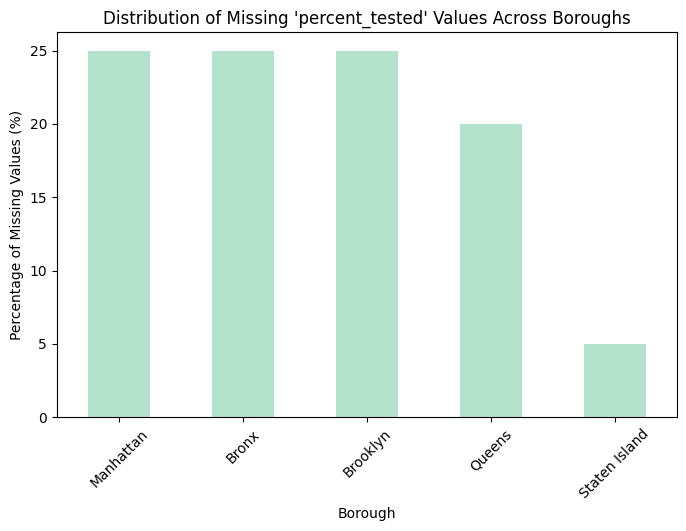

In [7]:
# Are the missing values concentrated in specific boroughs?
# Filter only rows where 'percent_tested' is missing (normalized to percentage)
missing_boroughs = schools[schools['percent_tested'].isnull()]['borough'].value_counts(normalize=True) * 100

missing_boroughs.plot(kind='bar', figsize=(8, 5), colormap='Pastel2')

plt.xlabel("Borough")
plt.ylabel("Percentage of Missing Values (%)")
plt.title("Distribution of Missing 'percent_tested' Values Across Boroughs")
plt.xticks(rotation=45)
plt.show()

The chart above shows that almost 75% of the missing values are distributed equally between Manhattan, Bronx, and Brooklyn (25% for each). Now let's see how these missing values affect, proportionally by their size, each borough by creating another bar plot:

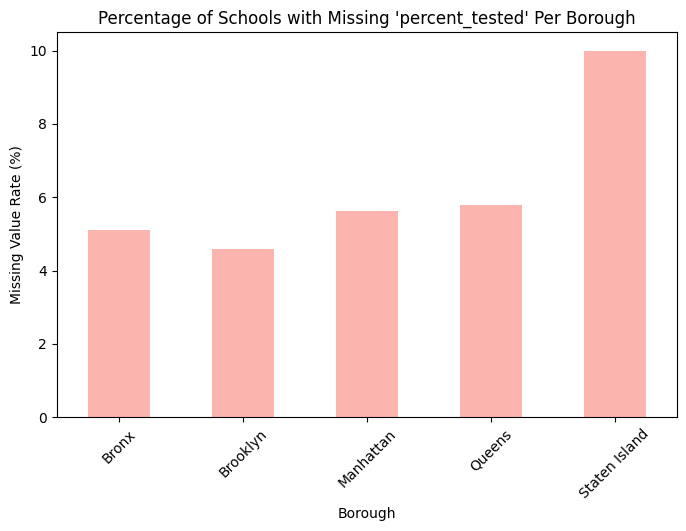

In [8]:
# Count total bourough per borough
total_boroughs = schools['borough'].value_counts()

# Count missing values per borough
missing_percent_tested_per_borough = schools[schools['percent_tested'].isnull()]['borough'].value_counts()

# Calculate missing value rate per borough
missing_rate = (missing_percent_tested_per_borough / total_boroughs) * 100

# Plot
missing_rate.plot(kind='bar', figsize=(8, 5), colormap='Pastel1')
plt.xlabel("Borough")
plt.ylabel("Missing Value Rate (%)")
plt.title("Percentage of Schools with Missing 'percent_tested' Per Borough")
plt.xticks(rotation=45)
plt.show()

We can notice that Staten Island is the most affected, proportionally, by the missing values. <br> So, to avoid the risk of missing 10% of the entries for this borough, let's input some values for this column for each borough by using the **Mean of the Borough**:

In [9]:
schools["percent_tested"] = schools["percent_tested"].fillna(schools.groupby("borough")["percent_tested"].transform('median'))

I could use .apply to fill the missing values with the mean, but I read that using .tranform is more efficient. <br> Let's see the difference:

- `apply()`: Applies the function to each group and then reallocates the values in the column. Less efficient because it involves multiple steps.
- `transform()`: Calculates a value for each group and returns a vector with the same size as the original column. More efficient and direct.

Now, what is the percentage of missing values?

In [10]:
missing_percentage = schools['percent_tested'].isna().sum() / len(schools['percent_tested']) * 100
print("Missing percentage:", missing_percentage)

Missing percentage: 0.0


Yey, now we are good to go!

# Answering the questions

## 1 - Which NYC schools have the best math results?
The best math results are at least 80% of the **maximum possible score of 800** for math.

In [11]:
minimum_math_best_score_schools = schools[schools["average_math"] >= (0.8*800)]

best_math_schools = minimum_math_best_score_schools[["school_name", "average_math"]].sort_values(by='average_math', ascending=False)

best_math_schools.head()

,school_name,average_math
88,Stuyvesant High School,754
170,Bronx High School of Science,714
93,Staten Island Technical High School,711
365,Queens High School for the Sciences at York Co...,701
68,"High School for Mathematics, Science, and Engi...",683


The schools listed above are the ones with the best math results.
The **Stuyvesant High School** have the best score for math. Good!

## 2 - What are the top 10 performing schools based on the combined SAT scores?

In [12]:
top_10_schools = schools[["school_name", "total_SAT"]].sort_values(by='total_SAT', ascending=False).iloc[0:10]

top_10_schools.head(10)

,school_name,total_SAT
88,Stuyvesant High School,2144
170,Bronx High School of Science,2041
93,Staten Island Technical High School,2041
174,High School of American Studies at Lehman College,2013
333,Townsend Harris High School,1981
365,Queens High School for the Sciences at York Co...,1947
5,Bard High School Early College,1914
280,Brooklyn Technical High School,1896
45,Eleanor Roosevelt High School,1889
68,"High School for Mathematics, Science, and Engi...",1889


We can see that **Stuyvesant High School** is not only the best in math, but is the best in general.

## 3 - Which single borough has the largest standard deviation in the combined SAT score?

In [13]:
# Calculate the standard deviation of `total_SAT` for each borough
std_dev = schools.groupby("borough")["total_SAT"].std().sort_values(ascending=False)

# Get the borough name with the largest std
largest_std_borough = std_dev.idxmax()

# Get only the entries from that borough
df_largest_std_dev = schools[schools["borough"]  == largest_std_borough]

# create a DataFrame containing only the data for this borough.
largest_std_dev = pd.DataFrame({
    "borough": [largest_std_borough],
    "num_schools": [df_largest_std_dev["school_name"].count().round(decimals=2)],
    "average_SAT": [df_largest_std_dev["total_SAT"].mean().round(decimals=2)],
    "std_SAT": [std_dev.max().round(decimals=2)]
})

print(largest_std_dev)

     borough  num_schools  average_SAT  std_SAT
0  Manhattan           89      1340.13   230.29


The standard deviation (`std_SAT`) measures how much SAT scores vary within a borough. A higher standard deviation means more variation in SAT scores among schools in that borough. <br>

It may suggest that some schools in the Manhattan borough have very high SAT scores, while others have very low SAT scores.
This could indicate inequality in education quality within the borough.